# DropConnect Is Effective in Modeling Uncertainty of Bayesian Deep Networks

### Aryan Mobiny, Hien V. Nguyen, Supratik Moulik, Naveen Garg, Carol C. Wu

<img src="imgs/fig1.png" width="5000" height="100" >

# 0. Import the required packages

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import os
import h5py
import numpy as np
import tensorflow as tf
from utils.plot_utils import *
from config import args
import pickle

# 1. Load the data

In [2]:
base_dir = os.getcwd()
data_dir = os.path.join(base_dir, 'data/test_2d_small.h5')
h5f = h5py.File(data_dir, 'r')
x_valid = h5f['x_norm'][:]
y_valid = h5f['y'][:]
h5f.close()

In [3]:
# print('Training images: {}'.format(x_train.shape))
# print('Training labels: {}\n'.format(y_train.shape))
print('Validation images: {}'.format(x_valid.shape))
print('Validation labels: {}'.format(y_valid.shape))

Validation images: (7, 512, 512, 1)
Validation labels: (7, 512, 512)


In [4]:
label_names = ['background', 'liver', 'spleen', 'kidney', 'bone', 'vessel']
i = 0

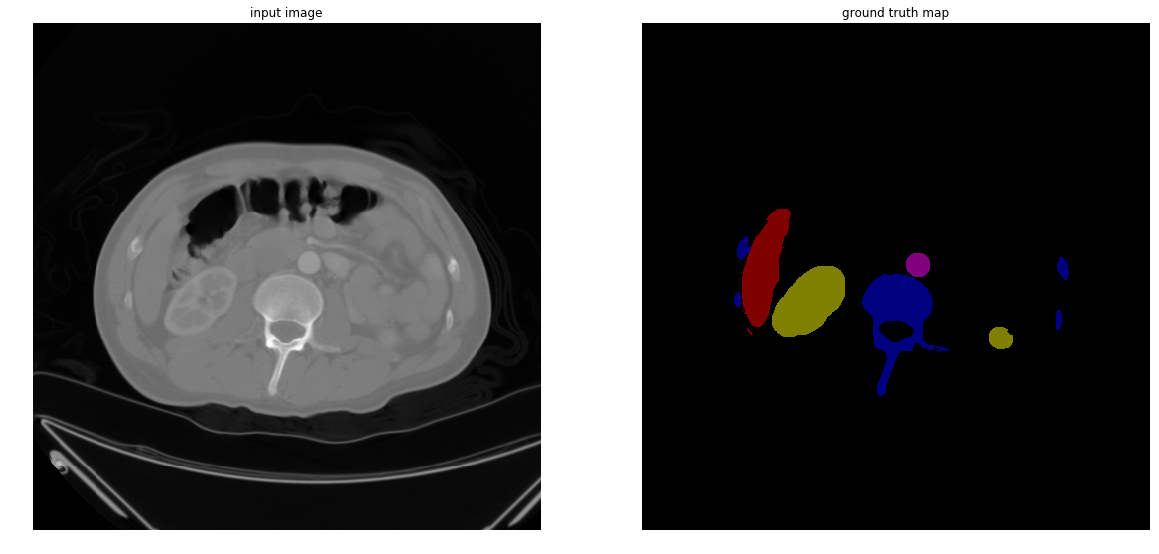

In [5]:
vis_data(x_valid[i,:,:,0], y_valid[i,:,:], label_names)
i += 1

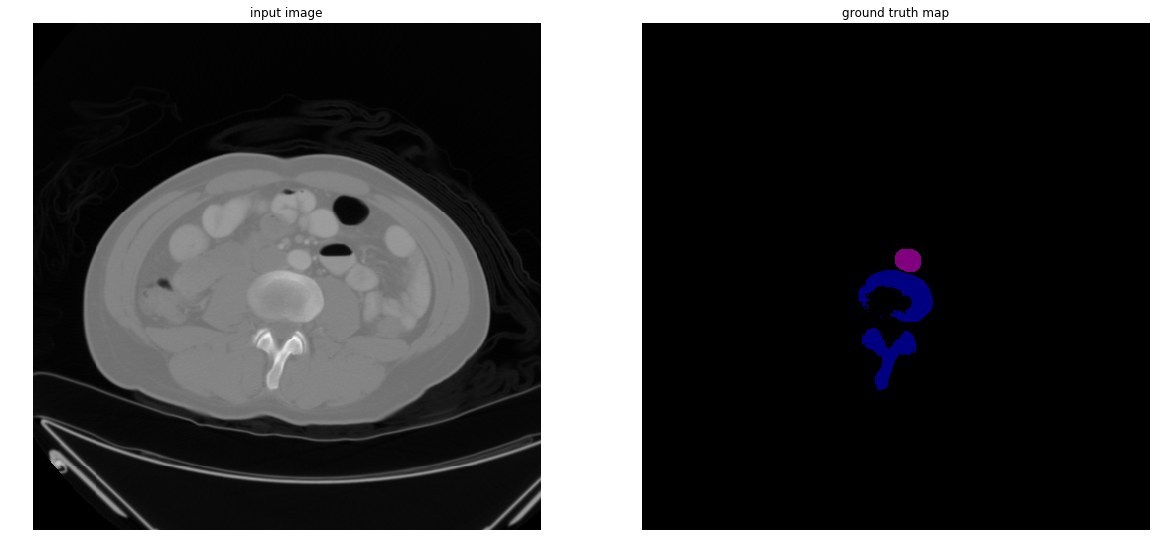

In [6]:
vis_data(x_valid[i,:,:,0], y_valid[i,:,:], label_names)

# 2. Create the Model

### 2D: U-net



<img src="imgs/fig3.png" width="800" height="100" >




### 3D: V-net

<img src="imgs/fig4.PNG" width="800" height="100" >



## 2.1. Model parameters

In [7]:
num_cls = 6 #'Number of output classes'
label_name = ['background', 'liver', 'spleen', 'kidney', 'bone', 'vessel']  # 'class names'
use_BN = True  # 'Adds Batch-Normalization to all convolutional layers'
start_channel_num = 16 #'start number of outputs for the first conv layer'
filter_size = 3 # 'Filter size for the conv and deconv layers'
pool_filter_size = 2 #'Filter size for pooling layers'
keep_prob = 0.75 # 'Probability of keeping a unit in drop-out'
run_name = 'dropout'# 'dropout or dropconnect'

### 2.1.1. Key of dropout

**After the activation of hidden layer, add**:

``` 
weights = weight_variable(layer_name, shape=shape)
layer = tf.nn.conv2d(input=inputs,
                     filter=weights,
                     strides=[1, stride, stride, 1],
                     padding="SAME")
layer = batch_norm(layer, is_train, layer_name)
layer = activation(layer)
outputs = tf.nn.dropout(layer, keep_prob, noise_shape, seed=seed) 
```

### 2.1.2. Key of dropconnect

**Drop the connecting weights before the we set the convolustion layer**:


```
weights = weight_variable(layer_name, shape=shape)
weights = tf.reshape(drop_connect(weights, keep_prob), shape=shape)
layer = tf.nn.conv2d(input=inputs,
                     filter=weights,
                     strides=[1, stride, stride, 1],
                     padding="SAME")
layer = batch_norm(layer, is_train, layer_name)
outputs = activation(layer)
```

## 2.2. Start the Evaluation

### 2.2.1. Monte Carlo Dropout

In [ ]:
# Don't run this; run the following cell to load the results
if run_name == 'dropout':
    from model.model_2D.VNet_dropout import VNet as Model

mask_prob_dropout = Model.MC_evaluate(x_valid, args)

In [8]:
# Load from the saved file
file_name = os.path.join(base_dir, 'dropout_pred_final.pkl')
with open(file_name, 'rb') as f:
    mask_prob_dropout = pickle.load(f)
    
mask_prob_dropout = mask_prob_dropout[:2]
print("Shape of mask_prob_dropout: ", np.array(mask_prob_dropout).shape)

Shape of mask_prob_dropout:  (2, 50, 512, 512, 6)


#### - Compute the predictions

$$ \mu_{p r e d} \approx \frac{1}{T} \sum_{t=1}^{T} p\left(y^{*} | \mathbf{x}^{*}, \hat{\mathbf{w}}_{t}\right) $$

In [9]:
prob_mean = np.nanmean(mask_prob_dropout, axis=1)        # prediction probabilities 
pred = np.argmax(prob_mean, axis=-1)                     # predicted class labels

print("Shape of prob_mean", prob_mean.shape)
print("Shape of prob: ", pred.shape)

Shape of prob_mean (2, 512, 512, 6)
Shape of prob:  (2, 512, 512)


#### - Compute the uncertainty estimates (using mutual information)

$$ {\hat{I}\left(\mathbf{y}^{*}, \mathbf{w} | \mathbf{x}^{*}, \mathcal{D}\right)=\hat{H}\left(\mathbf{y}^{*} | \mathbf{x}^{*}, \mathcal{D}\right)} {+\sum_{c} \frac{1}{T} \sum_{t=1}^{T} p\left(\mathbf{y}^{*}=c | \mathbf{x}^{*}, \hat{\mathbf{w}}_{t}\right) \log p\left(\mathbf{y}^{*}=c | \mathbf{x}^{*}, \hat{\mathbf{w}}_{t}\right)}$$
where

$$ \hat{H}\left(\mathbf{y}^{*} | \mathbf{x}^{*}, \mathcal{D}\right)=-\sum_{c} p_{\mathrm{MC}}\left(\mathbf{y}^{*}=c | \mathbf{x}^{*}\right) \log p_{\mathrm{MC}}\left(\mathbf{y}^{*}=c | \mathbf{x}^{*}\right) $$

In [10]:
def mutual_info(mean_prob, mc_prob):
    """
    computes the mutual information
    :param mean_prob: average MC probabilities of shape [batch_size, img_h, img_w, num_cls]
    :param mc_prob: List MC probabilities of length mc_simulations;
                    each of shape  of shape [batch_size, img_h, img_w, num_cls]
    :return: mutual information of shape [batch_size, img_h, img_w, num_cls]
    """
    eps = 1e-5
    first_term = -1 * np.sum(mean_prob * np.log(mean_prob + eps), axis=-1)
    second_term = np.sum(np.mean([prob * np.log(prob + eps) for prob in mc_prob], axis=0), axis=-1)
    return first_term + second_term

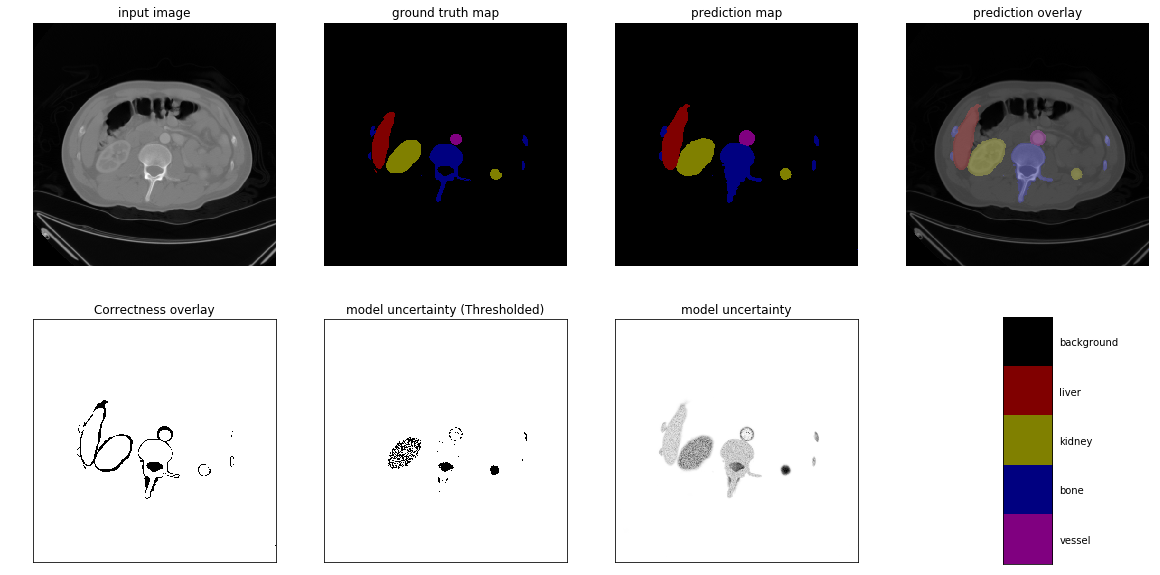

In [11]:
i = 0
MI = mutual_info(prob_mean[i], mask_prob_dropout[i])
vis_segmentation(x_valid[i], y_valid[i], pred[i], MI, None, label_names=np.array(label_name), Threshold=0.08)
i += 1

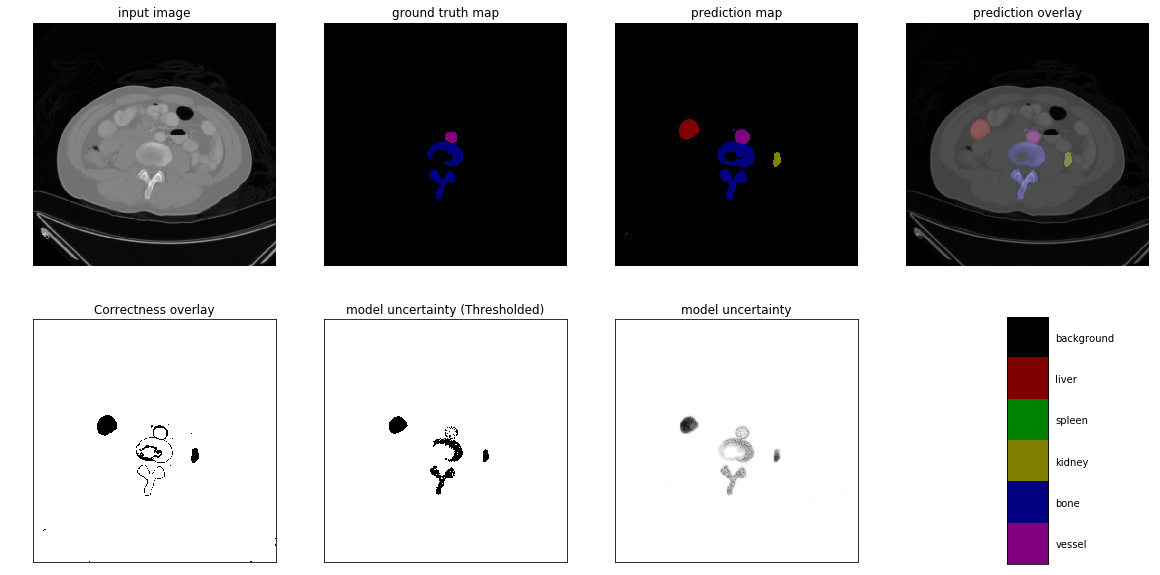

In [12]:
MI = mutual_info(prob_mean[i], mask_prob_dropout[i])
vis_segmentation(x_valid[i], y_valid[i], pred[i], MI, None, label_names=np.array(label_name), Threshold=0.08)

### 2.2.2. Monte Carlo Dropconnect

In [ ]:
# Don't run this; run the following cell to load the results
run_name == 'dropconnect'
if run_name == 'dropconnect':
    from model.model_2D.VNet_dropconnect import VNet as Model
    
mask_prob_dropconnect = Model.MC_evaluate(x_valid, args)

In [17]:
# Load from the saved array (instead of running the above loop)
file_name = os.path.join(base_dir, 'dropconnect_pred_final.pkl')
with open(file_name, 'rb') as f:
    mask_prob_dropconnect = pickle.load(f)

mask_prob_dropconnect = mask_prob_dropconnect[:2]
print("Shape of mask_prob_dropconnect: ", np.array(mask_prob_dropconnect).shape)

Shape of mask_prob_dropconnect:  (2, 50, 512, 512, 6)


#### - Compute the predictions

In [18]:
prob_mean = np.nanmean(mask_prob_dropconnect, axis=1)        # prediction probabilities of shape 
pred = np.argmax(prob_mean, axis=-1)                         # predicted class labels of shape
print("Shape of prob_mean", prob_mean.shape)
print("Shape of prob: ", pred.shape)

Shape of prob_mean (2, 512, 512, 6)
Shape of prob:  (2, 512, 512)


#### - Compute the uncertainty estimates (using mutual information)

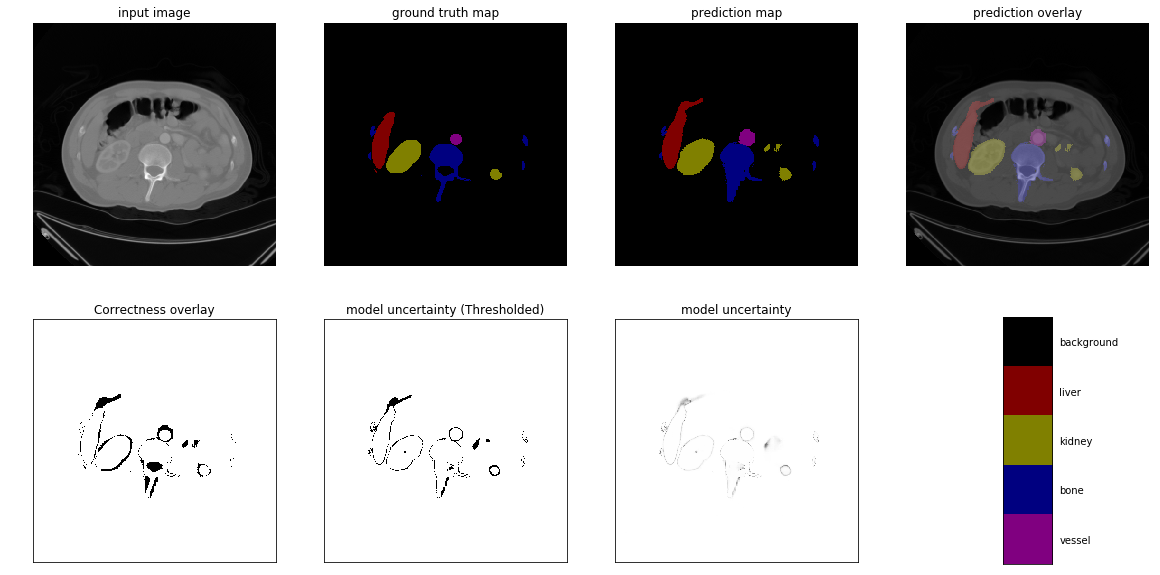

In [19]:
i = 0
MI = mutual_info(prob_mean[i], mask_prob_dropconnect[i])
vis_segmentation(x_valid[i], y_valid[i], pred[i], MI, None, label_names=np.array(label_name))
i += 1

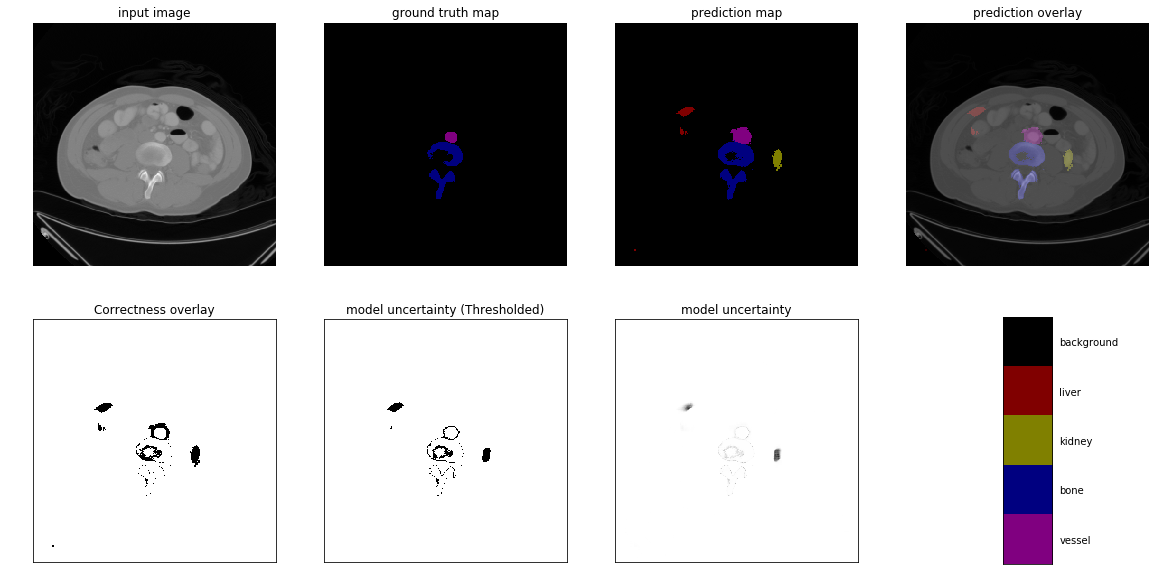

In [20]:
MI = mutual_info(prob_mean[i], mask_prob_dropconnect[i])
vis_segmentation(x_valid[i], y_valid[i], pred[i], MI, None, label_names=np.array(label_name))
i += 1

# 3. Compare the prediction performance

## 3.1. Dropout

--------------------
** IoU & ACC **  
Mean IoU = 73.7%
     - background class: IoU=97.9%, ACC=98.0%
     - liver class: IoU=71.5%, ACC=98.7%
     - spleen class: IoU=71.9%, ACC=99.5%
     - kidney class: IoU=75.3%, ACC=91.2%
     - bone class: IoU=75.2%, ACC=99.8%
     - vessel class: IoU=50.4%, ACC=99.2%
--------------------

## 3.2. Dropconnect

--------------------
** IoU & ACC **  
Mean IoU = 80.2%
     - background class: IoU=98.7%, ACC=98.8%
     - liver class: IoU=90.5%, ACC=99.1%
     - spleen class: IoU=77.6%, ACC=99.1%
     - kidney class: IoU=80.3%, ACC=98.1%
     - bone class: IoU=84.0%, ACC=99.8%
     - vessel class: IoU=49.9%, ACC=99.9%
--------------------